In [22]:
import random
from os import path

import numpy as np
import torch
import torchvision.transforms as transforms
from torchsummary import summary

import dataloaders
import networks.dcgan as dcgan
import networks.utils as utils

### Setup CUDA / Multiprocessing related variables

In [23]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda'  #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threads:  8


### Setup Parameters

In [24]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [25]:
### Data
DATA_PATH = path.join("data", "tmdb-64")
TABLE_PATH = path.join("data", "tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3  # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
PADDING_MODE = "reflect"
COLORMODE = "RGB"

### Training
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs", "dcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 1
SAVE_FAKES_EVERY_N_EPOCHS = 1

#MODEL_TO_LOAD = path.join(OUT_PATH, "2022-09-25_16-38-53/gan_at_epoch_0001.pt")
MODEL_TO_LOAD = None

### Load dataset

In [26]:
# Poster subset:
GENRE = None
GENRE_LOGIC = 'and'
OG_LANG = None
YEAR = None
RUNTIME = (40, np.inf)
MAX_NUM = None
SORT = None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREADS,
                                           pin_memory=PIN_MEMORY)

Sample dataset:

The dataset has 224094 entries.


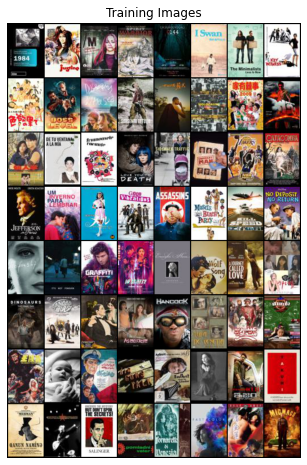

In [27]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [28]:
generator, discriminator = dcgan.create_gan(img_size=IMAGE_SIZE, img_ratio=IMAGE_SIZE_RATIO,
                                            num_img_channels=NUM_IMG_CHANNELS,
                                            num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                            base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G,
                                            base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE,
                                            device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, IMAGE_SIZE_RATIO, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, IMAGE_SIZE * IMAGE_SIZE_RATIO // 2, IMAGE_SIZE))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 6, 4]         819,200
       BatchNorm2d-2            [-1, 512, 6, 4]           1,024
              ReLU-3            [-1, 512, 6, 4]               0
   ConvTranspose2d-4           [-1, 256, 12, 8]       2,097,152
       BatchNorm2d-5           [-1, 256, 12, 8]             512
              ReLU-6           [-1, 256, 12, 8]               0
   ConvTranspose2d-7          [-1, 128, 24, 16]         524,288
       BatchNorm2d-8          [-1, 128, 24, 16]             256
              ReLU-9          [-1, 128, 24, 16]               0
  ConvTranspose2d-10           [-1, 64, 48, 32]         131,072
      BatchNorm2d-11           [-1, 64, 48, 32]             128
             ReLU-12           [-1, 64, 48, 32]               0
  ConvTranspose2d-13            [-1, 3, 96, 64]           3,072
             Tanh-14        

In [29]:
from contextlib import redirect_stdout

with open(path.join(OUT_PATH, "architectures.txt"), "w") as file:
    with redirect_stdout(file):
        print("Generator:")
        summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, IMAGE_SIZE_RATIO, 1))
        print("\nDiscriminator:")
        summary(discriminator, input_size=(3, IMAGE_SIZE * IMAGE_SIZE_RATIO // 2, IMAGE_SIZE))

In [30]:
trainer = dcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE,
                               num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO,
                               d_params=discriminator.parameters(), g_params=generator.parameters(),
                               learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

[0/19]	Loss_D: 0.3365	Loss_G: 3.3328	D(x): 0.8392	D(G(z)): 0.1138 / 0.0685: 100%|██████████| 1751/1751 [03:44<00:00,  7.79it/s]


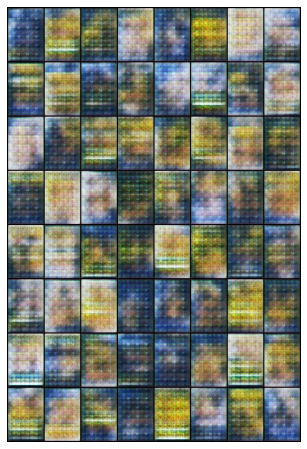

[1/19]	Loss_D: 0.4955	Loss_G: 4.4069	D(x): 0.8097	D(G(z)): 0.1723 / 0.0430: 100%|██████████| 1751/1751 [03:40<00:00,  7.92it/s]


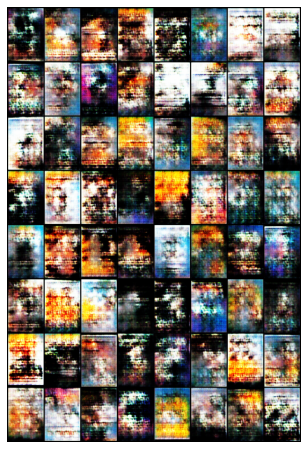

[2/19]	Loss_D: 0.9151	Loss_G: 4.8053	D(x): 0.8789	D(G(z)): 0.3823 / 0.0518: 100%|██████████| 1751/1751 [03:42<00:00,  7.86it/s]


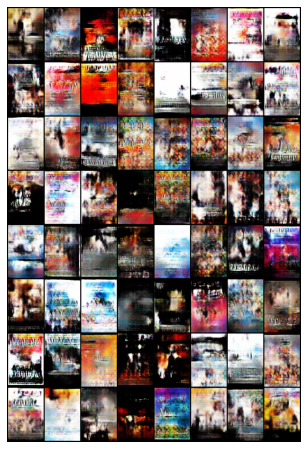

[3/19]	Loss_D: 0.3343	Loss_G: 3.4595	D(x): 0.8451	D(G(z)): 0.1092 / 0.0562: 100%|██████████| 1751/1751 [03:39<00:00,  7.99it/s]


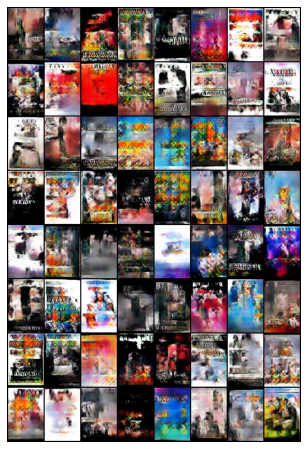

[4/19]	Loss_D: 0.1697	Loss_G: 4.4772	D(x): 0.8861	D(G(z)): 0.0345 / 0.0253: 100%|██████████| 1751/1751 [03:34<00:00,  8.15it/s] 


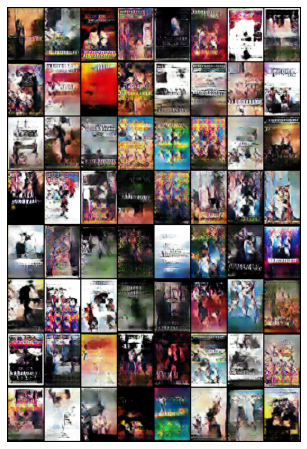

[5/19]	Loss_D: 0.7439	Loss_G: 4.2895	D(x): 0.7286	D(G(z)): 0.2245 / 0.0443: 100%|██████████| 1751/1751 [03:34<00:00,  8.15it/s]  


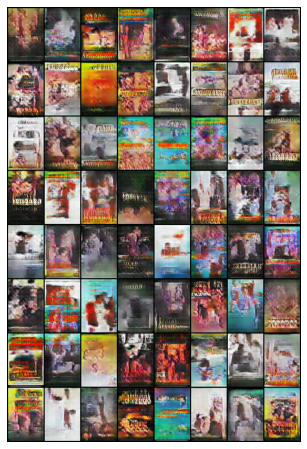

[6/19]	Loss_D: 0.7013	Loss_G: 3.9232	D(x): 0.8637	D(G(z)): 0.3427 / 0.0398: 100%|██████████| 1751/1751 [03:34<00:00,  8.17it/s] 


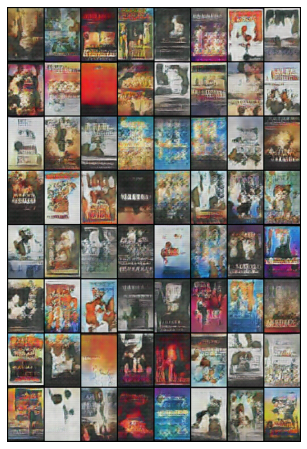

[7/19]	Loss_D: 0.3339	Loss_G: 2.4852	D(x): 0.7890	D(G(z)): 0.0387 / 0.1289: 100%|██████████| 1751/1751 [03:35<00:00,  8.13it/s] 


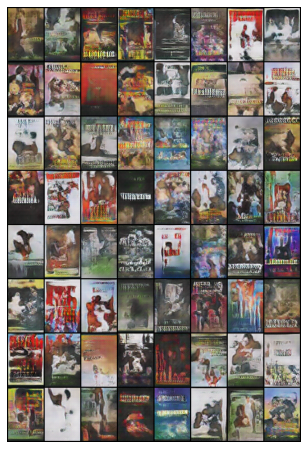

[8/19]	Loss_D: 0.0891	Loss_G: 4.2458	D(x): 0.9448	D(G(z)): 0.0222 / 0.0310: 100%|██████████| 1751/1751 [03:48<00:00,  7.68it/s] 


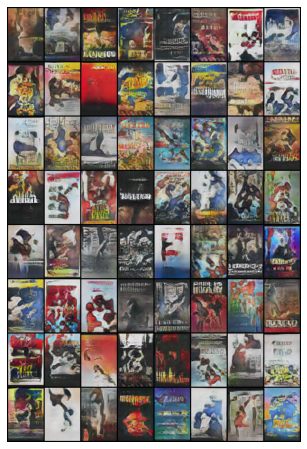

[9/19]	Loss_D: 0.1787	Loss_G: 3.1362	D(x): 0.8806	D(G(z)): 0.0397 / 0.0697: 100%|██████████| 1751/1751 [04:23<00:00,  6.66it/s] 


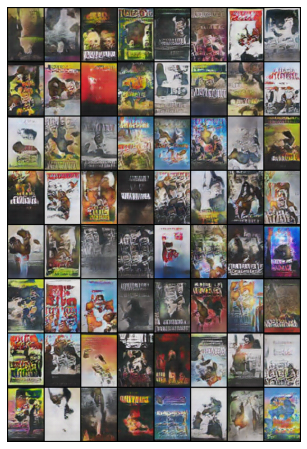

[10/19]	Loss_D: 0.0933	Loss_G: 5.0738	D(x): 0.9371	D(G(z)): 0.0199 / 0.0153: 100%|██████████| 1751/1751 [04:30<00:00,  6.48it/s] 


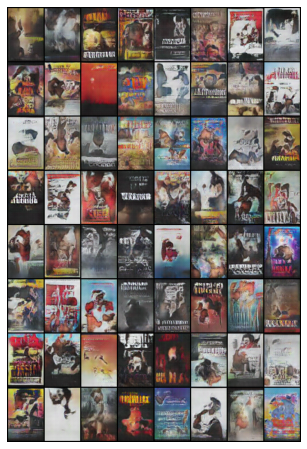

[11/19]	Loss_D: 0.1185	Loss_G: 5.5019	D(x): 0.9384	D(G(z)): 0.0336 / 0.0167: 100%|██████████| 1751/1751 [04:26<00:00,  6.57it/s] 


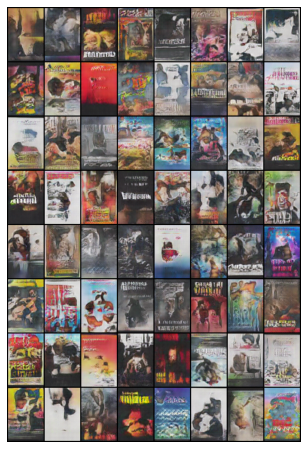

[12/19]	Loss_D: 0.5392	Loss_G: 3.3916	D(x): 0.7316	D(G(z)): 0.0906 / 0.0777: 100%|██████████| 1751/1751 [04:29<00:00,  6.51it/s] 


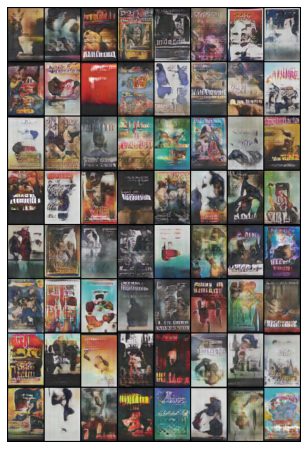

[13/19]	Loss_D: 0.0356	Loss_G: 4.5241	D(x): 0.9879	D(G(z)): 0.0224 / 0.0198: 100%|██████████| 1751/1751 [04:23<00:00,  6.64it/s] 


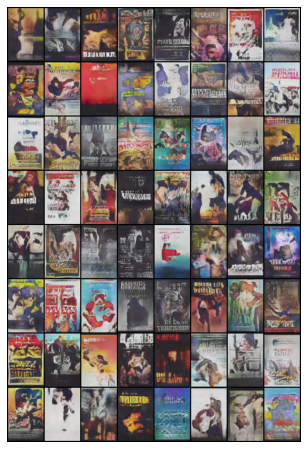

[14/19]	Loss_D: 0.1775	Loss_G: 5.5331	D(x): 0.9675	D(G(z)): 0.1170 / 0.0087: 100%|██████████| 1751/1751 [03:58<00:00,  7.35it/s]  


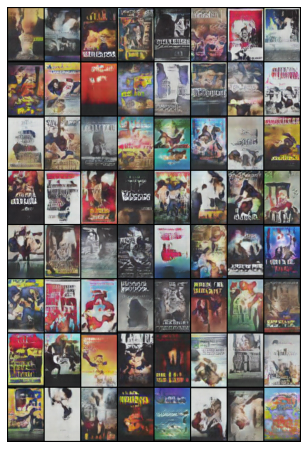

[15/19]	Loss_D: 3.2071	Loss_G: 8.8494	D(x): 0.9948	D(G(z)): 0.8573 / 0.0228: 100%|██████████| 1751/1751 [03:59<00:00,  7.31it/s] 


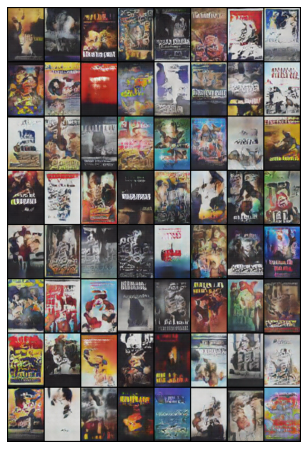

[16/19]	Loss_D: 0.3770	Loss_G: 5.1111	D(x): 0.9817	D(G(z)): 0.2441 / 0.0167: 100%|██████████| 1751/1751 [03:58<00:00,  7.34it/s] 


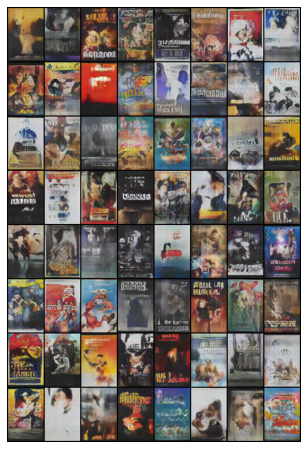

[17/19]	Loss_D: 0.1111	Loss_G: 4.9061	D(x): 0.9552	D(G(z)): 0.0520 / 0.0241: 100%|██████████| 1751/1751 [04:02<00:00,  7.23it/s] 


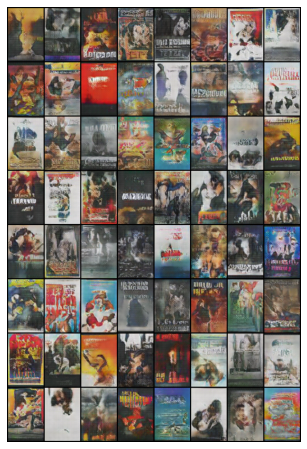

[18/19]	Loss_D: 0.2792	Loss_G: 3.1190	D(x): 0.8454	D(G(z)): 0.0517 / 0.1247: 100%|██████████| 1751/1751 [03:54<00:00,  7.47it/s] 


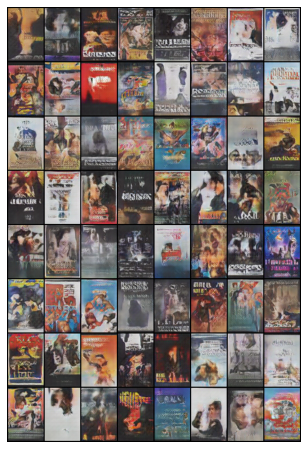

[19/19]	Loss_D: 0.0767	Loss_G: 6.2235	D(x): 0.9912	D(G(z)): 0.0604 / 0.0040: 100%|██████████| 1751/1751 [04:02<00:00,  7.21it/s] 


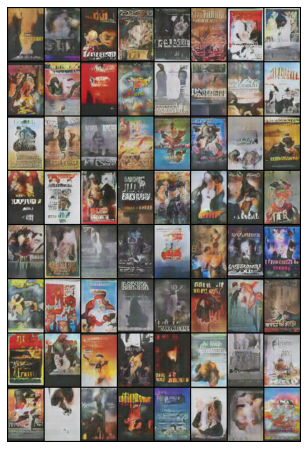

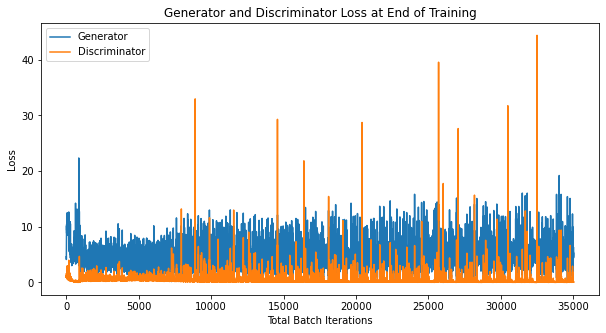

In [31]:
SHOW_GRAPHS = True
trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device,
              fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS, model_snap=SAVE_MODEL_EVERY_N_EPOCHS,
              model_to_load=MODEL_TO_LOAD, show_graphs=SHOW_GRAPHS)

### Show results

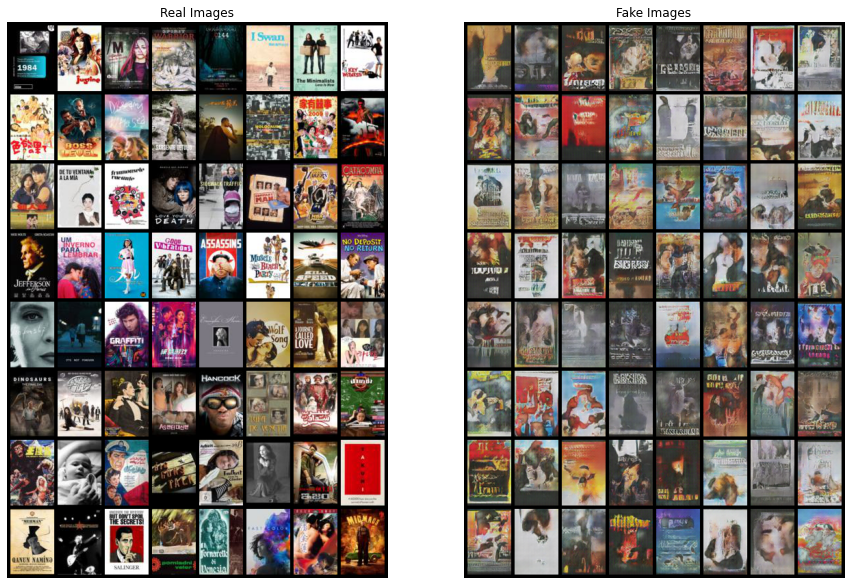

In [32]:
utils.plot_reals_vs_fakes(generator, trainer, sample_reals, NUM_SAMPLES,
                          path.join(trainer.last_out_dir, "real_vs_fake.png"), device)